# SAM8905 Reverb FX - ALG 0 Analysis

Algorithm 0 is the **input conditioning** algorithm that:
1. Reads input samples from the sound SAM via external waveform memory
2. Writes samples to SRAM circular buffer for delay line processing

This notebook verifies ALG 0 operation by:
- Providing a simulated 16-bit sine input buffer
- Tracking SRAM writes to verify circular buffer operation

In [59]:
# Reload interpreter module to pick up changes
import importlib
import sam8905_interpreter
importlib.reload(sam8905_interpreter)
from sam8905_interpreter import (
    SAM8905Interpreter,
    plot_waveform,
    print_state,
    sign_extend_12,
    sign_extend_19,
    MASK12, MASK19
)
print("Interpreter module reloaded")

Interpreter module reloaded


In [60]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from sam8905_interpreter import (
    SAM8905Interpreter,
    plot_waveform,
    print_state,
    sign_extend_12,
    sign_extend_19,
    MASK12, MASK19
)
from sam8905_aram_decoder import decode_algorithm, decode_instruction, format_instruction

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 4)

## ALG 0 from Keyfox10 FX Chip

22kHz mode: 64 instructions (PC00-PC61, PC62-63 reserved)

In [61]:
# A-RAM 0x00-0x3F: 22kHz ALG 0 (D-RAM ALG=0, Used by Slot 4)
# From WIP_fx_reverb_analysis.md
aram_alg0 = [
    0x00F7,  # PC00: RM 0, <WXY>
    0x607F,  # PC01: RM 12, <WA>
    0x58BF,  # PC02: RM 11, <WB>
    0x5A5F,  # PC03: RADD 11, <WA, WM>
    0x30BF,  # PC04: RM 6, <WB>
    0x5DDF,  # PC05: RP 11, <WM> [WSP]
    0x082D,  # PC06: RM 1, <WA, WB, WPHI, WWF>
    0x593F,  # PC07: RM 11, <WA, WB> [WSP]
    0x5ADF,  # PC08: RADD 11, <WM>
    0x58F7,  # PC09: RM 11, <WXY>
    0x406F,  # PC10: RM 8, <WA, WPHI>
    0x2CDF,  # PC11: RP 5, <WM>
    0x48BF,  # PC12: RM 9, <WB>
    0x58F7,  # PC13: RM 11, <WXY>
    0x42DF,  # PC14: RADD 8, <WM>
    0x749F,  # PC15: RP 14, <WB, WM>
    0x68F7,  # PC16: RM 13, <WXY>  -- loads Y from D[13] for SRAM write
    0x38FD,  # PC17: RM 7, <WWF>   -- sets SRAM bank
    0x7FFB,  # PC18: RSP 15, <clrB> [WSP]  -- WWE: write Y to SRAM
    0x7FFB,  # PC19: RSP 15, <clrB> [WSP]  -- WWE: write pulse
    0x7EFB,  # PC20: RSP 15, <clrB>
    0x7EFB,  # PC21: RSP 15, <clrB>
    0x7FFF,  # PC22: RSP 15, <-> [WSP]
    0x406F,  # PC23: RM 8, <WA, WPHI>
    0x50BF,  # PC24: RM 10, <WB>
    0x42DF,  # PC25: RADD 8, <WM>
    0x683F,  # PC26: RM 13, <WA, WB>
    0x7A3F,  # PC27: RADD 15, <WA, WB>
    0x7A3F,  # PC28: RADD 15, <WA, WB>
    0x7A3F,  # PC29: RADD 15, <WA, WB>
    0x7A3F,  # PC30: RADD 15, <WA, WB>
    0x7A3F,  # PC31: RADD 15, <WA, WB>
    0x7A3F,  # PC32: RADD 15, <WA, WB>
    0x7A3F,  # PC33: RADD 15, <WA, WB>
    0x7AF7,  # PC34: RADD 15, <WXY>  -- loads Y from A+B for SRAM write
    0x7FFB,  # PC35: RSP 15, <clrB> [WSP]  -- WWE
    0x7FFB,  # PC36: RSP 15, <clrB> [WSP]  -- WWE
    0x7EFB,  # PC37: RSP 15, <clrB>
    0x7EFB,  # PC38: RSP 15, <clrB>
    0x7FFF,  # PC39: RSP 15, <-> [WSP]
    0x78FD,  # PC40: RM 15, <WWF>
    0x18EF,  # PC41: RM 3, <WPHI>
    0x58F7,  # PC42: RM 11, <WXY>  -- waveform read
    0x7FFF,  # PC43: RSP 15, <-> [WSP]
    0x50EF,  # PC44: RM 10, <WPHI>
    0x08FD,  # PC45: RM 1, <WWF>
    0x24DF,  # PC46: RSP 4, <WM>   -- D[4] = 0 (RSP emits 0)
    0x7FFF,  # PC47: RSP 15, <-> [WSP]
    0x20F7,  # PC48: RM 4, <WXY>   -- waveform read with D[4]
    0x287F,  # PC49: RM 5, <WA>
    0x00EF,  # PC50: RM 0, <WPHI>  -- PHI = D[0], may trigger X update
    0x7CBF,  # PC51: RP 15, <WB>   -- B = product
    0x2ADF,  # PC52: RADD 5, <WM>  -- D[5] = A+B
    0x20F7,  # PC53: RM 4, <WXY>   -- waveform read
    0x707F,  # PC54: RM 14, <WA>
    0x7CBF,  # PC55: RP 15, <WB>
    0x28EF,  # PC56: RM 5, <WPHI>
    0x78FD,  # PC57: RM 15, <WWF>
    0x10F7,  # PC58: RM 2, <WXY>   -- FINAL waveform read from D[2]
    0x7A7F,  # PC59: RADD 15, <WA>
    0x7CBF,  # PC60: RP 15, <WB>   -- B = product (input sample?)
    0x6A5B,  # PC61: RADD 13, <WA, WM, clrB>  -- D[13] = A+B, output buffer
]

# Pad to 64 instructions (PC62-63 are reserved NOPs)
aram_alg0 += [0x7FFF] * (64 - len(aram_alg0))

print(f"ALG 0: {len(aram_alg0)} instructions")
print()
print(decode_algorithm(aram_alg0, 0))

ALG 0: 64 instructions

=== Algorithm 0 ===

PC00: 00F7  RM 0, <WXY>
PC01: 607F  RM 12, <WA>
PC02: 58BF  RM 11, <WB>
PC03: 5A5F  RADD 11, <WA, WM>
PC04: 30BF  RM 6, <WB>
PC05: 5DDF  RP 11, <WM, WSP> ***
PC06: 082D  RM 1, <WA, WB, WPHI, WWF>
PC07: 593F  RM 11, <WA, WB, WSP> ***
PC08: 5ADF  RADD 11, <WM>
PC09: 58F7  RM 11, <WXY>
PC10: 406F  RM 8, <WA, WPHI>
PC11: 2CDF  RP 5, <WM>
PC12: 48BF  RM 9, <WB>
PC13: 58F7  RM 11, <WXY>
PC14: 42DF  RADD 8, <WM>
PC15: 749F  RP 14, <WB, WM>
PC16: 68F7  RM 13, <WXY>
PC17: 38FD  RM 7, <WWF>
PC18: 7FFB  RSP, <clearB, WSP> ***
PC19: 7FFB  RSP, <clearB, WSP> ***
PC20: 7EFB  RSP, <clearB>
PC21: 7EFB  RSP, <clearB>
PC22: 7FFF  RSP, <WSP> ***
PC23: 406F  RM 8, <WA, WPHI>
PC24: 50BF  RM 10, <WB>
PC25: 42DF  RADD 8, <WM>
PC26: 683F  RM 13, <WA, WB>
PC27: 7A3F  RADD, <WA, WB>
PC28: 7A3F  RADD, <WA, WB>
PC29: 7A3F  RADD, <WA, WB>
PC30: 7A3F  RADD, <WA, WB>
PC31: 7A3F  RADD, <WA, WB>
PC32: 7A3F  RADD, <WA, WB>
PC33: 7A3F  RADD, <WA, WB>
PC34: 7AF7  RADD, <WXY>
P

## D-RAM Configuration (Slot 4)

In [62]:
# D-RAM for Slot 4 (ALG 0)
dram_slot4 = [
    0x00000,  # word 0: Zero constant (Y init, PHI reset)
    0x50080,  # word 1: SRAM address config (WF=0x50>>1=0x28, PHI bits)
    0x00400,  # word 2: SRAM read address for final output
    0x40000,  # word 3: Phase offset = -262144 (most negative 19-bit)
    0x00080,  # word 4: Working register (gets cleared at PC46)
    0x00000,  # word 5: Delayed sample accumulator
    0x7FFFF,  # word 6: -1 constant (for saturation check)
    0x40402,  # word 7: SRAM bank select (WF=0x40402>>9=0x201, but only 9 bits used=0x01)
    0x00100,  # word 8: Delay line base pointer
    0x00080,  # word 9: Delay increment 1
    0x00180,  # word 10: Delay increment 2
    0x0007C,  # word 11: Signal amplitude state [val=124]
    0x00000,  # word 12: Initial A value
    0x00000,  # word 13: Working buffer / output destination
    0x00000,  # word 14: Product storage
    0x34080,  # word 15: SRAM config + IDLE=0, ALG=0
]

print("D-RAM Slot 4 configuration:")
for i, val in enumerate(dram_slot4):
    signed = sign_extend_19(val)
    wf_bits = (val >> 9) & 0x1FF
    phi_bits = (val >> 7) & 0xFFF
    print(f"  D[{i:2d}] = 0x{val:05X} ({signed:+8d})  WF[8:0]={wf_bits:03X}  PHI[11:0]={phi_bits:03X}")

D-RAM Slot 4 configuration:
  D[ 0] = 0x00000 (      +0)  WF[8:0]=000  PHI[11:0]=000
  D[ 1] = 0x50080 ( -196480)  WF[8:0]=080  PHI[11:0]=A01
  D[ 2] = 0x00400 (   +1024)  WF[8:0]=002  PHI[11:0]=008
  D[ 3] = 0x40000 ( -262144)  WF[8:0]=000  PHI[11:0]=800
  D[ 4] = 0x00080 (    +128)  WF[8:0]=000  PHI[11:0]=001
  D[ 5] = 0x00000 (      +0)  WF[8:0]=000  PHI[11:0]=000
  D[ 6] = 0x7FFFF (      -1)  WF[8:0]=1FF  PHI[11:0]=FFF
  D[ 7] = 0x40402 ( -261118)  WF[8:0]=002  PHI[11:0]=808
  D[ 8] = 0x00100 (    +256)  WF[8:0]=000  PHI[11:0]=002
  D[ 9] = 0x00080 (    +128)  WF[8:0]=000  PHI[11:0]=001
  D[10] = 0x00180 (    +384)  WF[8:0]=000  PHI[11:0]=003
  D[11] = 0x0007C (    +124)  WF[8:0]=000  PHI[11:0]=000
  D[12] = 0x00000 (      +0)  WF[8:0]=000  PHI[11:0]=000
  D[13] = 0x00000 (      +0)  WF[8:0]=000  PHI[11:0]=000
  D[14] = 0x00000 (      +0)  WF[8:0]=000  PHI[11:0]=000
  D[15] = 0x34080 ( +213120)  WF[8:0]=1A0  PHI[11:0]=681


## Input Sample Buffer Simulation

The FX chip receives audio from the sound SAM via external memory reads.
- WF address 0x80-0xFF: Input sample buffer (from sound SAM)
- WA0 (PHI bit 0): Selects low/high byte of 16-bit sample

We'll create a 16-bit sine wave buffer and provide it via `waveform_read` callback.

Input buffer: 1024 samples at 22050Hz
Sine frequency: 440Hz, Amplitude: ±16000
Sample range: [-15999, 15999]


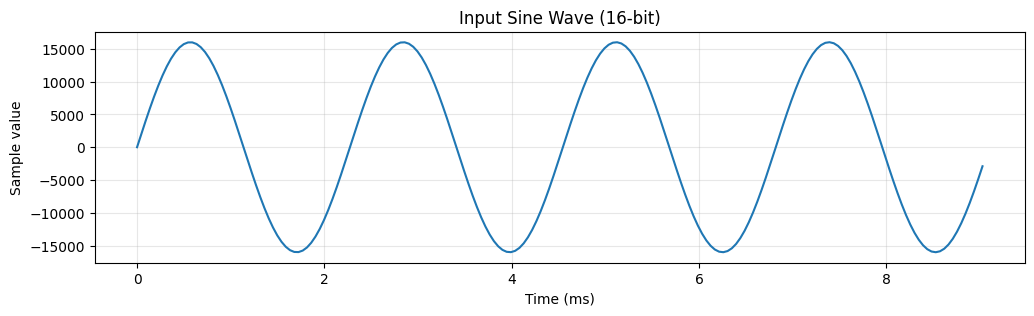

In [63]:
# Create 16-bit sine wave input buffer
# At 22.05kHz sample rate, one period of 440Hz = 50 samples
SAMPLE_RATE = 22050
FREQ = 440
AMPLITUDE = 16000  # 16-bit amplitude (±16000)

# Generate enough samples for testing
NUM_INPUT_SAMPLES = 1024
t = np.arange(NUM_INPUT_SAMPLES) / SAMPLE_RATE
input_buffer_16bit = (AMPLITUDE * np.sin(2 * np.pi * FREQ * t)).astype(np.int16)

print(f"Input buffer: {len(input_buffer_16bit)} samples at {SAMPLE_RATE}Hz")
print(f"Sine frequency: {FREQ}Hz, Amplitude: ±{AMPLITUDE}")
print(f"Sample range: [{input_buffer_16bit.min()}, {input_buffer_16bit.max()}]")

# Plot first few periods
plt.figure(figsize=(12, 3))
plt.plot(t[:200]*1000, input_buffer_16bit[:200])
plt.xlabel('Time (ms)')
plt.ylabel('Sample value')
plt.title('Input Sine Wave (16-bit)')
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
# Track input reads and SRAM writes
input_read_log = []   # List of (frame, address, value, sample_16bit)
sram_write_log = []   # List of (frame, address, data, phi, byte_select, sram_byte, pc)
sram_buffer = {}      # Simulated SRAM: address -> value

frame_counter = 0

def waveform_read_callback(address):
    """External waveform read callback.
    
    Address format: WF[7:0] << 12 | PHI[11:0]
    - WF 0x00-0x7F: SRAM delay buffer (lower 15 bits = SRAM address)
    - WF 0x80-0xFF: Input sample buffer (from sound SAM)
    
    For input (WF >= 0x80):
    - PHI[0] = 0: Read high byte of 16-bit sample
    - PHI[0] = 1: Read low byte of 16-bit sample
    
    SRAM address format (32KB = 15 bits):
    - Address bits [14:0] = (WF[2:0] << 12) | PHI[11:0]
    """
    wf = (address >> 12) & 0xFF
    phi = address & 0xFFF
    
    if wf >= 0x80:
        # Input sample buffer
        # WF[6:0] selects the sample index (we'll use a simple mapping)
        sample_idx = frame_counter % len(input_buffer_16bit)
        sample_16bit = int(input_buffer_16bit[sample_idx])
        
        # PHI[0] selects byte: 0=high, 1=low
        if phi & 1:
            # Low byte
            result = sample_16bit & 0xFF
        else:
            # High byte (sign-extended)
            result = (sample_16bit >> 8) & 0xFF
        
            # Sign-extend 8-bit to 12-bit
            if result & 0x80:
                result |= 0xF00
        
        result <<= 3
        
        input_read_log.append((frame_counter, address, result, sample_16bit))
        return result & 0xFFF
    else:
        # SRAM delay buffer read
        # Use lower 15 bits of address directly: (WF[2:0] << 12) | PHI[11:0]
        sram_addr = address & 0x7FFF
        result = sram_buffer.get(sram_addr, 0)

        if not (phi & 1):
            # Sign-extend 8-bit to 12-bit
            if result & 0x80:
                result |= 0xF00
        
        result <<= 3
        
        return result & 0xFFF

def waveform_write_callback(address, data, phi, pc):
    """SRAM write callback.
    
    Address format (32KB = 15 bits): (WF[2:0] << 12) | PHI[11:0]
    Data: 12-bit signed value (Y register)
    phi: Full PHI register value (phi[0] = byte select: 0=high, 1=low)
    pc: Program counter (instruction index) - identifies which WWE sequence
    
    ALG 0 WWE sequences:
    - PC18/19: First sequence (writes D[13] old value)
    - PC35/36: Second sequence (writes computed new value)
    """
    # Use lower 15 bits of address directly
    sram_addr = address & 0x7FFF
    
    # Store actual 8-bit value that would go to SRAM (Y[10:3])
    sram_byte = (data >> 3) & 0xFF
    byte_select = phi & 1  # 0=high byte, 1=low byte
    
    sram_buffer[sram_addr] = data & 0xFFF
    sram_write_log.append((frame_counter, sram_addr, data, phi, byte_select, sram_byte, pc))

print("Callbacks defined (with corrected SRAM address format).")

Callbacks defined (with corrected SRAM address format).


## Run ALG 0

In [65]:
# Create interpreter and configure
sam = SAM8905Interpreter()

# Set 22kHz mode (SSR=1)
sam.state.control_reg = 0x08  # Bit 3 = SSR

# Load A-RAM (ALG 0 at offset 0 for 22kHz mode)
sam.load_aram(aram_alg0, offset=0)

# Load D-RAM for slot 4
sam.load_dram(slot=4, words=dram_slot4)

# Connect callbacks
sam.waveform_read = waveform_read_callback
sam.waveform_write = waveform_write_callback

# Enable tracing for first few frames
sam.trace_enabled = True

print("Interpreter configured for ALG 0 in 22kHz mode.")
print(f"Control reg: 0x{sam.state.control_reg:02X} (SSR={(sam.state.control_reg >> 3) & 1})")

Interpreter configured for ALG 0 in 22kHz mode.
Control reg: 0x08 (SSR=1)


In [66]:
# Clear logs and reset frame counter
input_read_log = []
sram_write_log = []
sram_buffer = {}
frame_counter = 0
sam.trace_output = []

# Run for several frames
NUM_FRAMES = 256

for i in range(NUM_FRAMES):
    frame_counter = i
    # Only trace first 2 frames
    sam.trace_enabled = (i < 2)
    sam.execute_frame(active_slots=[4])

print(f"Ran {NUM_FRAMES} frames")
print(f"Input reads: {len(input_read_log)}")
print(f"SRAM writes: {len(sram_write_log)}")
print(f"SRAM locations used: {len(sram_buffer)}")

Ran 256 frames
Input reads: 1280
SRAM writes: 1024
SRAM locations used: 512


In [67]:
# Show instruction trace for first frame
print("First frame instruction trace:")
print("=" * 80)
for line in sam.trace_output[:64]:  # First 64 = one frame
    print(line)

First frame instruction trace:
S04 PC00: 00F7  RM 0, <WXY>  -> x=0x00000, y=0x00000, mul=0x00000
S04 PC01: 607F  RM 12, <WA>  -> a=0x00000
S04 PC02: 58BF  RM 11, <WB>  -> b=0x0007C
S04 PC03: 5A5F  RADD 11, <WA, WM>  -> a=0x0007C
S04 PC04: 30BF  RM 6, <WB>  -> b=0x7FFFF
S04 PC05: 5DDF  RP 11, <WM, WSP>
S04 PC06: 082D  RM 1, <WA, WB, WPHI, WWF>  -> a=0x50080, b=0x50080, phi=0x00A01, wf=0x00080
S04 PC07: 593F  RM 11, <WA, WB, WSP>  -> a=0x00200, b=0x0007C
S04 PC08: 5ADF  RADD 11, <WM>  -> 
S04 PC09: 58F7  RM 11, <WXY>  -> x=0x00000, y=0x00004, mul=0x00000
S04 PC10: 406F  RM 8, <WA, WPHI>  -> a=0x00100, phi=0x00002
S04 PC11: 2CDF  RP 5, <WM>
S04 PC12: 48BF  RM 9, <WB>  -> b=0x00080
S04 PC13: 58F7  RM 11, <WXY>  -> x=0x00000, y=0x00004, mul=0x00000
S04 PC14: 42DF  RADD 8, <WM>  -> 
S04 PC15: 749F  RP 14, <WB, WM>  -> b=0x00000
S04 PC16: 68F7  RM 13, <WXY>  -> x=0x00000, y=0x00000, mul=0x00000
S04 PC17: 38FD  RM 7, <WWF>  -> wf=0x00002
S04 PC18: 7FFB  RSP, <clearB, WSP>  -> b=0x00000
S04 PC1

## Analyze Input Reads

In [68]:
print(f"Input read summary ({len(input_read_log)} reads):")
print()
if input_read_log:
    print("First 10 reads:")
    for frame, addr, val, sample in input_read_log[:10]:
        wf = (addr >> 12) & 0xFF
        phi = addr & 0xFFF
        byte_sel = "LOW" if phi & 1 else "HIGH"
        print(f"  Frame {frame:3d}: addr=0x{addr:05X} (WF=0x{wf:02X} PHI=0x{phi:03X}) "
              f"-> 0x{val:03X} ({sign_extend_12(val):+5d}) [{byte_sel}] sample={sample:+6d}")
else:
    print("No input reads recorded!")
    print("This suggests ALG 0 may not be reading from input address space (WF >= 0x80).")

Input read summary (1280 reads):

First 10 reads:
  Frame   0: addr=0x80A01 (WF=0x80 PHI=0xA01) -> 0x000 (   +0) [LOW] sample=    +0
  Frame   0: addr=0x80002 (WF=0x80 PHI=0x002) -> 0x000 (   +0) [HIGH] sample=    +0
  Frame   0: addr=0x80002 (WF=0x80 PHI=0x002) -> 0x000 (   +0) [HIGH] sample=    +0
  Frame   0: addr=0x80003 (WF=0x80 PHI=0x003) -> 0x000 (   +0) [LOW] sample=    +0
  Frame   0: addr=0x80000 (WF=0x80 PHI=0x000) -> 0x000 (   +0) [HIGH] sample=    +0
  Frame   1: addr=0x80A01 (WF=0x80 PHI=0xA01) -> 0x680 (+1664) [LOW] sample= +2000
  Frame   1: addr=0x80006 (WF=0x80 PHI=0x006) -> 0x038 (  +56) [HIGH] sample= +2000
  Frame   1: addr=0x80006 (WF=0x80 PHI=0x006) -> 0x038 (  +56) [HIGH] sample= +2000
  Frame   1: addr=0x80003 (WF=0x80 PHI=0x003) -> 0x680 (+1664) [LOW] sample= +2000
  Frame   1: addr=0x80000 (WF=0x80 PHI=0x000) -> 0x038 (  +56) [HIGH] sample= +2000


## Analyze SRAM Writes

In [69]:
print(f"SRAM write summary ({len(sram_write_log)} writes):")
print()
if sram_write_log:
    print("First 20 writes:")
    # New log format: (frame, addr, data, phi, byte_select, sram_byte, pc)
    for frame, addr, data, phi, byte_sel, sram_byte, pc in sram_write_log[:20]:
        bs_str = "HIGH" if byte_sel == 0 else "LOW "
        print(f"  Frame {frame:3d}: PC{pc:02d} SRAM[0x{addr:04X}] PHI={phi:03X} {bs_str} "
              f"= 0x{data & 0xFFF:03X} ({sign_extend_12(data):+5d}) -> byte 0x{sram_byte:02X}")
    
    print(f"\nSRAM address range: 0x{min(w[1] for w in sram_write_log):04X} - 0x{max(w[1] for w in sram_write_log):04X}")
    
    # Count writes by PC
    pc_counts = {}
    for w in sram_write_log:
        pc_counts[w[6]] = pc_counts.get(w[6], 0) + 1
    print(f"\nWrites by PC:")
    for pc in sorted(pc_counts.keys()):
        print(f"  PC{pc:02d}: {pc_counts[pc]} writes")
    
    # Count high vs low byte writes
    high_writes = sum(1 for w in sram_write_log if w[4] == 0)
    low_writes = sum(1 for w in sram_write_log if w[4] == 1)
    print(f"\nHigh byte writes (PHI[0]=0): {high_writes}")
    print(f"Low byte writes (PHI[0]=1): {low_writes}")
else:
    print("No SRAM writes recorded!")
    print("Check WWE trigger conditions (RSP + clearB + WSP with WF < 0x80).")

SRAM write summary (1024 writes):

First 20 writes:
  Frame   0: PC18 SRAM[0x2002] PHI=002 HIGH = 0x000 (   +0) -> byte 0x00
  Frame   0: PC19 SRAM[0x2002] PHI=002 HIGH = 0x000 (   +0) -> byte 0x00
  Frame   0: PC35 SRAM[0x2003] PHI=003 LOW  = 0x000 (   +0) -> byte 0x00
  Frame   0: PC36 SRAM[0x2003] PHI=003 LOW  = 0x000 (   +0) -> byte 0x00
  Frame   1: PC18 SRAM[0x2006] PHI=006 HIGH = 0x000 (   +0) -> byte 0x00
  Frame   1: PC19 SRAM[0x2006] PHI=006 HIGH = 0x000 (   +0) -> byte 0x00
  Frame   1: PC35 SRAM[0x2007] PHI=007 LOW  = 0x002 (   +2) -> byte 0x00
  Frame   1: PC36 SRAM[0x2007] PHI=007 LOW  = 0x002 (   +2) -> byte 0x00
  Frame   2: PC18 SRAM[0x200A] PHI=00A HIGH = 0x000 (   +0) -> byte 0x00
  Frame   2: PC19 SRAM[0x200A] PHI=00A HIGH = 0x000 (   +0) -> byte 0x00
  Frame   2: PC35 SRAM[0x200B] PHI=00B LOW  = 0x046 (  +70) -> byte 0x08
  Frame   2: PC36 SRAM[0x200B] PHI=00B LOW  = 0x046 (  +70) -> byte 0x08
  Frame   3: PC18 SRAM[0x200E] PHI=00E HIGH = 0x000 (   +0) -> byte 0x00

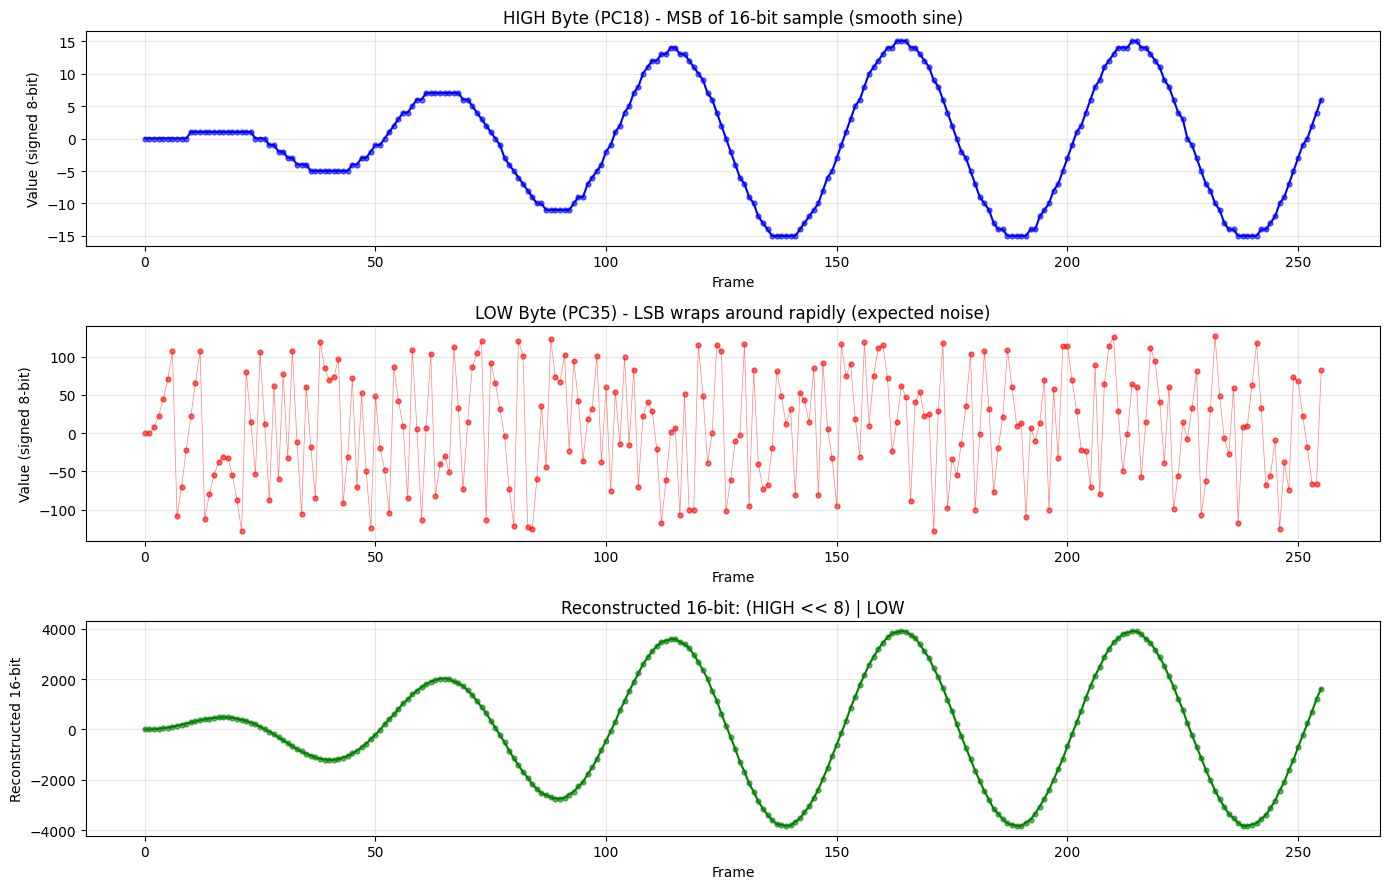

--- Analysis ---
HIGH byte (MSB): Range [-15, 15]
LOW byte (LSB): Range [-128, 127]
Reconstructed 16-bit: Range [-3832, 3904]

Input sine amplitude was: 16000


In [70]:
if sram_write_log:
    # Extract 8-bit SRAM values (WD3-WD10 = Y[10:3]) from each WWE sequence
    # Format: (frame, addr, data, phi, byte_select, sram_byte, pc)
    
    # Convert unsigned 8-bit to signed (as stored in SRAM with sign extension)
    def to_signed_8(val):
        if val > 127:
            return val - 256
        return val
    
    # PC18 writes HIGH byte, PC35 writes LOW byte
    # sram_byte is already Y[10:3] extracted
    pc18_data = [(w[0], to_signed_8(w[5])) for w in sram_write_log if w[6] == 18]
    pc35_data = [(w[0], to_signed_8(w[5])) for w in sram_write_log if w[6] == 35]
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 9))
    
    # Plot 1: HIGH byte - should be smooth sine (MSB)
    ax1 = axes[0]
    if pc18_data:
        frames_18, vals_18 = zip(*pc18_data)
        ax1.plot(frames_18, vals_18, 'b-', linewidth=1.5)
        ax1.scatter(frames_18, vals_18, s=12, c='blue', alpha=0.6)
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Value (signed 8-bit)')
    ax1.set_title('HIGH Byte (PC18) - MSB of 16-bit sample (smooth sine)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: LOW byte - expected to be noisy (LSB wraps around)
    ax2 = axes[1]
    if pc35_data:
        frames_35, vals_35 = zip(*pc35_data)
        ax2.plot(frames_35, vals_35, 'r-', linewidth=0.5, alpha=0.5)
        ax2.scatter(frames_35, vals_35, s=12, c='red', alpha=0.6)
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Value (signed 8-bit)')
    ax2.set_title('LOW Byte (PC35) - LSB wraps around rapidly (expected noise)')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Reconstruct 16-bit using SAME frame HIGH+LOW
    ax3 = axes[2]
    
    # Group by frame
    writes_by_frame = {}
    for frame, addr, data, phi, byte_sel, sram_byte, pc in sram_write_log:
        if frame not in writes_by_frame:
            writes_by_frame[frame] = {}
        if pc == 18:  # HIGH
            writes_by_frame[frame]['high_8bit'] = sram_byte
        elif pc == 35:  # LOW
            writes_by_frame[frame]['low_8bit'] = sram_byte
    
    # Reconstruct using 8-bit bytes from same frame
    reconstructed = []
    for frame in sorted(writes_by_frame.keys()):
        d = writes_by_frame[frame]
        if 'high_8bit' in d and 'low_8bit' in d:
            sample_16 = (d['high_8bit'] << 8) | d['low_8bit']
            if sample_16 > 32767:
                sample_16 -= 65536
            reconstructed.append((frame, sample_16))
    
    if reconstructed:
        r_frames, r_values = zip(*reconstructed)
        ax3.plot(r_frames, r_values, 'g-', linewidth=1.5)
        ax3.scatter(r_frames, r_values, s=12, c='green', alpha=0.6)
    ax3.set_xlabel('Frame')
    ax3.set_ylabel('Reconstructed 16-bit')
    ax3.set_title('Reconstructed 16-bit: (HIGH << 8) | LOW')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("--- Analysis ---")
    if pc18_data:
        print(f"HIGH byte (MSB): Range [{min(vals_18)}, {max(vals_18)}]")
    if pc35_data:
        print(f"LOW byte (LSB): Range [{min(vals_35)}, {max(vals_35)}]")
    if reconstructed:
        print(f"Reconstructed 16-bit: Range [{min(r_values)}, {max(r_values)}]")
    
    # Compare to input sine amplitude
    print(f"\nInput sine amplitude was: {AMPLITUDE}")

## Final State Inspection

In [71]:
print_state(sam.state, slot=4)

SAM8905 Register State
  A = 0x020DE  (+8414)
  B = 0x00000  (+0)
  X = 0x3DB  (+987)
  Y = 0x008  (+8)
  PHI = 0x1DF  (479)
  WF = 0x1A0
  MUL = 0x001EE  (+494)

  CARRY = False
  CLEAR_RQST = True
  INT_MOD = False

  MIX_L = 0  MIX_R = 0
  L_ACC = +0  R_ACC = +0

D-RAM Slot 4:
  D[ 0] = 0x00000  (+0)
  D[ 1] = 0x50080  (-196480)
  D[ 2] = 0x00400  (+1024)
  D[ 3] = 0x40000  (-262144)
  D[ 4] = 0x7FFE1  (-31)
  D[ 5] = 0x0EFC4  (+61380)
  D[ 6] = 0x7FFFF  (-1)
  D[ 7] = 0x40402  (-261118)
  D[ 8] = 0x20100  (+131328)
  D[ 9] = 0x00080  (+128)
  D[10] = 0x00180  (+384)
  D[11] = 0x0F87C  (+63612)
  D[12] = 0x00000  (+0)
  D[13] = 0x020DE  (+8414)
  D[14] = 0x01F00  (+7936)
  D[15] = 0x34080  (+213120)


## Debug: Check WF Values During Execution

If no input reads occur, check what WF values are being set.

In [72]:
# Check D-RAM values that set WF
print("D-RAM words used for WWF (WF = bus[17:9]):")
for i, val in enumerate(dram_slot4):
    wf = (val >> 9) & 0x1FF
    if wf != 0:
        wf_type = "INPUT" if wf >= 0x100 else ("SRAM" if wf < 0x80 else "INPUT(8bit)")
        print(f"  D[{i:2d}] = 0x{val:05X} -> WF = 0x{wf:03X} ({wf_type})")

print()
print("Note: WF >= 0x100 is internal waveform, WF < 0x80 is SRAM, WF 0x80-0xFF is input.")

D-RAM words used for WWF (WF = bus[17:9]):
  D[ 1] = 0x50080 -> WF = 0x080 (INPUT(8bit))
  D[ 2] = 0x00400 -> WF = 0x002 (SRAM)
  D[ 6] = 0x7FFFF -> WF = 0x1FF (INPUT)
  D[ 7] = 0x40402 -> WF = 0x002 (SRAM)
  D[15] = 0x34080 -> WF = 0x1A0 (INPUT)

Note: WF >= 0x100 is internal waveform, WF < 0x80 is SRAM, WF 0x80-0xFF is input.


In [73]:
# Export SRAM buffer for use in ALG 1 notebook
# First, let's run ALG 0 for enough frames to populate the buffer

import pickle

# Check current sram_buffer state
print(f"Current SRAM buffer: {len(sram_buffer)} entries")
if sram_buffer:
    print(f"Address range: 0x{min(sram_buffer.keys()):04X} - 0x{max(sram_buffer.keys()):04X}")
    
    # Show some sample values
    print("\nSample SRAM contents:")
    for addr in sorted(sram_buffer.keys())[:10]:
        val = sram_buffer[addr]
        val_signed = val if val < 2048 else val - 4096
        print(f"  SRAM[0x{addr:04X}] = 0x{val:03X} ({val_signed:+5d})")
else:
    print("SRAM buffer is empty - need to run ALG 0 first")

Current SRAM buffer: 512 entries
Address range: 0x2002 - 0x23FF

Sample SRAM contents:
  SRAM[0x2002] = 0x000 (   +0)
  SRAM[0x2003] = 0x000 (   +0)
  SRAM[0x2006] = 0x000 (   +0)
  SRAM[0x2007] = 0x002 (   +2)
  SRAM[0x200A] = 0x000 (   +0)
  SRAM[0x200B] = 0x046 (  +70)
  SRAM[0x200E] = 0x000 (   +0)
  SRAM[0x200F] = 0x0B2 ( +178)
  SRAM[0x2012] = 0x001 (   +1)
  SRAM[0x2013] = 0x16A ( +362)


In [30]:
# Run ALG 0 for more frames to fill entire SRAM bank
# With corrected SRAM addressing: (WF[2:0] << 12) | PHI[11:0]
# PHI advances by 4 per frame, full 12-bit range = 4096 values
# Need 4096 frames to cycle through all PHI values once

# Clear and re-run
sam.reset()
sam.load_aram(aram_alg0, offset=0)
sam.load_dram(4, dram_slot4)
sam.state.control_reg = 0x08  # SSR=1 for 22kHz mode
sam.waveform_read = waveform_read_callback
sam.waveform_write = waveform_write_callback

sram_buffer.clear()
sram_write_log.clear()
input_read_log.clear()

NUM_FRAMES = 4096  # Full PHI cycle

for i in range(NUM_FRAMES):
    frame_counter = i
    sam.run(1, active_slots=[4])

print(f"Ran {NUM_FRAMES} frames")
print(f"SRAM locations used: {len(sram_buffer)}")
if sram_buffer:
    print(f"Address range: 0x{min(sram_buffer.keys()):04X} - 0x{max(sram_buffer.keys()):04X}")

# Save to file for ALG 1
import pickle
with open('alg0_sram_buffer.pkl', 'wb') as f:
    pickle.dump(sram_buffer, f)
print(f"\nSaved SRAM buffer to alg0_sram_buffer.pkl")

Ran 4096 frames
SRAM locations used: 2048
Address range: 0x2002 - 0x2FFF

Saved SRAM buffer to alg0_sram_buffer.pkl
